## Import Libraries

In [1]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data             
import numpy as np           # mathematical library for working with numerical data
import os, sys

# from metrics import *
# Add the previous directory to sys.path
sys.path.append(os.path.abspath('../'))

# Now you can import the metrics module
from metrics import *
import os 

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data
from sklearn.metrics import mean_squared_error, r2_score 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 


# Function to filter out LightGBM warnings
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings


In [2]:
root_dir = r"C:\Users\pault\OneDrive - University of Oklahoma\GRA - Bio-Manufacturing\1. ML-Cytovance-OU-Research"
os.chdir(root_dir)

## Preprocessing

> Drop invariant columns

In [3]:
# drop invariant columns 
def drop_invariant_columns(df):
    """
    This function takes a list of DataFrames and drops specified invariant columns from each DataFrame.

    Parameters:
    experiment_data (list): List of pandas DataFrames.
    invariant_cols (list): List of column names to be dropped from each DataFrame.

    Returns:
    list: A new list of DataFrames with invariant columns dropped.
    """
    invariant_cols = ['input_vessel_type',	'input_vessel_volume',	'input_vessel_name',	'input_agitation_rpm',	'input_DO_%',	
                  'input_pH_setpoint',	'input_gas_flow',	'input_air_%',	'input_O2',	'input_Temp_c',	'input_media_type',	
                  'input_feed_type',	'input_glucose_limit']
    

    # Create a copy of the DataFrame to avoid modifying the original data.
    updated_df = df.drop(columns=invariant_cols, axis=1)
    return updated_df




> Missing Value Imputation

In [4]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor    

def convert_WCW_zero(df):
    df['output_WCW_gl'] = df.apply(lambda row: 0 if row['input_Timepoint (hr)'] in [0,1, 2] else row['output_WCW_gl'], axis=1)
    # df['output_WCW_gl'] = df.apply(lambda row: 0 if row.name in [pd.Timestamp("2024-01-01 00:00:00"), pd.Timestamp("2024-01-01 01:00:00"), pd.Timestamp("2024-01-01 02:00:00")] else row['output_WCW_gl'], axis=1)
    return df


def impute_missing_values_iteratively(X_a, exclude=None):
    # Convert specific values to zero based on conditions
    X_a = convert_WCW_zero(X_a)
    X = X_a.copy()

    # Normalize the exclude parameter to be a list if it's not None or already a list
    if exclude is not None and not isinstance(exclude, list):
        exclude = [exclude]

    for col in X.columns:
        # Check if column is excluded or if it's 'input_Timepoint (hr)'
        if exclude is not None and col in exclude:
            continue

        # Process columns that are not excluded and meet the conditions
        if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100, random_state=0),  # the estimator to predict the NA
        initial_strategy='mean',  # how will NA be imputed in step 1
        max_iter=10,  # number of cycles
        imputation_order='ascending',  # the order in which to impute the variables
        n_nearest_features=None,  # whether to limit the number of predictors
        skip_complete=True,  # whether to ignore variables without NA
        random_state=0,)

    # Select columns that are now either originally numeric or successfully converted from object
    numeric_cols = [col for col in X.select_dtypes(include=['number']).columns if col not in exclude] if exclude is not None else X.select_dtypes(include=['number']).columns

    # Impute missing values only in the selected numeric columns that are not excluded
    X_imputed = imputer.fit_transform(X[numeric_cols])
    X_a[numeric_cols] = X_imputed

    return X_a 

> Scale and Concat

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Use StandardScaler for this
scale_cols = ['output_WCW_gl', 'output_agitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 'output_Ph', 
              'output_feed_%', 'output_feed', 'output_Temp', 'output_glycerol_gl', 
              'output_glucose_gl', 'output_acetate_mmol_l', 'output_phosphate_mmol_l']

def scale_and_concat(X, columns_to_transform = scale_cols, train = False, scaler = None):
    """
    Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_transform (list): List of column names to be scaled.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with scaled columns.
    """
    
    # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns_to_transform if col in X.columns]
    
    if train == True:
        # scaler = MinMaxScaler() # Initialize the scaler 
        scaler = StandardScaler()   # Initialize the scaler
        scaler.fit(X[valid_columns])  # Fit only on the training set
    else:
        scaler = scaler

    # Create a copy of the original DataFrame
    df_concatenated = X.copy()

    # Scale the selected columns
    scaled_columns = scaler.transform(X[valid_columns])

    # Create a DataFrame with the scaled columns
    df_scaled = pd.DataFrame(scaled_columns, columns=valid_columns, index=X.index)
            
    # Concatenate the scaled columns with the rest of the DataFrame
    df_concatenated = pd.concat([df_concatenated.drop(columns=valid_columns, axis = 1), df_scaled], axis=1)

    if train == True:
        return df_concatenated, scaler
    else:
        return df_concatenated
    



## Building the Model

> Titer Value imputation

In [6]:

import random 


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names, num_impute = len(experiment_names), fraction_impute=0.8):  # Add fraction_impute parameter
    df_list = []
    impute_batches = np.random.choice(batch_names, size=num_impute, replace=False) 
    for b_name in batch_names:
        df = pd.read_csv(f"titer/data/{b_name}.csv")
        df = drop_invariant_columns(df) 
        df.name = b_name
        df['batch'] = b_name
        
        # Find the first point where 'output_phosphate_mmol_l' <= 5
        condition_met_idx = df[df['output_phosphate_mmol_l'] <= 5].index.min()
        df['original_titer'] = df['output_titre_µgl'].copy()  # this copies the original titer for use in plotting 
        
        # Check if such a point exists
        if pd.notnull(condition_met_idx) and condition_met_idx > 1:
            # Calculate the index two rows up from the found point
            start_idx = max(condition_met_idx - 2, 0) 
            # Set 'output_titre_µgl' to 0.0 from start_idx to the beginning of the dataset
            df.loc[:start_idx, 'output_titre_µgl'] = 0.0
            
        # Find the last index with 'output_titre_µgl' == 0.0
        last_zero_idx = df[df['output_titre_µgl'] == 0.0].index.max() 

        # Determine the last non-NaN value or use the threshold
        if pd.isnull(df['output_titre_µgl'].iloc[-1]):
            final_value = random.uniform(0.3, 2.2)  # Threshold value if the last value is NaN
        else:
            final_value = df['output_titre_µgl'].dropna().iloc[-1]  # Last non-NaN value

        # Define the start and end indices for filling
        start_i = last_zero_idx + 1 if pd.notnull(last_zero_idx) else 0
        end_i = df.index.max() - 1  # Exclude the last time point

        # Apply the exponential function to fill missing values
        num_points = end_i - start_i + 1
        exp_values = np.linspace(0, 1, num_points)
        exp_values = final_value * (np.exp(exp_values) - 1) / (np.exp(1) - 1)  # Normalized exponential

        # Randomly select 60% of the indices to impute
        num_impute_points = int(num_points * fraction_impute)
        indices_to_impute = sorted(random.sample(range(start_i, end_i + 1), num_impute_points))

        for i, val in zip(indices_to_impute, exp_values[:num_impute_points]):
            if b_name in impute_batches:
                df.loc[i, 'output_titre_µgl'] = val
                df['input_batch'] = b_name

        # Set the final value
        if pd.isnull(df.loc[end_i + 1, 'output_titre_µgl']):
            df.loc[end_i + 1, 'output_titre_µgl'] = final_value

        df_list.append(df)
        
    return df_list 
  


def concatenate_impute_split(experiment_names):
    
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data, exclude = ['output_titre_µgl', 'input_batch', 'original_titer'])  # Impute missing values iteratively to avoid over-fitting on the test set

    # Split the data back into the original batches using the 'batch' column and return as a list
    # batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    batched_dataframes_list = [group for _, group in full_data_inputed.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def titer_imputation(experiment_names):
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Trial and Error: scale and cocatenate the dataset
    dataset = pd.concat(df_batch_list, ignore_index=True)

    return dataset



dataset = titer_imputation(experiment_names)

In [7]:
dataset

,input_Timepoint (hr),output_OD600,output_WCW_gl,output_agitation,output_air_%,output_D0_%,output_gasflow,output_O2,output_Ph,output_feed_%,output_feed,output_Temp,output_glycerol_gl,output_glucose_gl,output_acetate_mmol_l,output_phosphate_mmol_l,output_titre_µgl,batch,original_titer,input_batch
0,0.0,0.353000,0.000,1185.440000,100.000000,96.810000,5.010000,0.000000,6.910000,0.00,0.00000,30.19,6.4300,0.243000,1.9500,18.0000,0.000000,exp_210623_1,NaN,exp_210623_1
1,2.0,0.547000,0.000,1185.320000,100.000000,97.950000,5.000000,0.000000,6.775341,0.00,0.00000,29.99,5.2310,0.181900,3.7795,21.8014,0.000000,exp_210623_1,NaN,exp_210623_1
2,4.0,1.590000,0.000,1185.220000,100.000000,94.600000,5.000000,0.000000,6.850000,0.00,0.00000,30.01,6.4305,-0.004392,9.5241,27.5919,0.000000,exp_210623_1,NaN,exp_210623_1
3,6.0,4.460000,56.805,1184.830000,100.000000,82.450000,5.000000,0.000000,6.780000,0.00,0.00000,30.04,4.0480,-0.005319,15.6948,25.3705,0.000000,exp_210623_1,NaN,exp_210623_1
4,8.0,11.320000,51.770,1184.500000,100.000000,66.110000,5.000000,0.000000,6.710000,0.00,0.00000,29.99,0.0000,0.000000,15.6100,14.4700,0.000000,exp_210623_1,NaN,exp_210623_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,32.0,83.600000,207.500,1184.912964,99.576492,40.890980,4.793379,0.422386,6.194422,10.60,0.36040,25.99,0.2718,19.202700,4.0200,-0.0100,0.339295,exp_220822_4,NaN,exp_220822_4
680,36.0,87.400000,208.500,1184.800049,99.456673,40.179340,4.711772,0.543087,6.226009,9.01,0.30634,26.00,0.0097,18.399210,2.7800,-0.0200,0.488778,exp_220822_4,NaN,exp_220822_4
681,40.0,93.266667,217.500,1184.574951,99.654694,40.592091,4.850256,0.344494,6.214839,7.66,0.26044,26.01,0.1204,16.133740,4.1000,-0.0300,NaN,exp_220822_4,NaN,exp_220822_4
682,44.0,93.400000,216.500,1185.463989,99.543571,37.069462,4.800520,0.463291,6.221002,6.32,0.21488,25.98,0.0099,11.673240,4.8400,-0.1100,0.661216,exp_220822_4,NaN,exp_220822_4


In [8]:
# Control variables
    # Feed Type --> not in the dataset since it is invariant 
    # output_Ph (pH)
    # output_Temp (Temperature)
    # output_D0_% (Dissolved Oxygen Percentage)
    # Induction OD/Feed OD --> not in the dataset 

# Other Features
    # input_Timepoint (hr)
    # output_OD600 (OD600nm)
    # output_WCW_gl (Wet cell weight)
    # Agitation   (output_agitation)
    # output_air_% (Air)
    # output_gasflow (Gas Flow)
    # output_O2 (Oxygen)
    # output_feed_% (Feed Percentage)
    # output_feed (Feed)
    # output_glycerol_gl (Glycerol)
    # output_glucose_gl (Glucose)
    # output_acetate_mmol_l (Acetate)
    # output_phosphate_mmol_l (Phosphate)
    
# Target variable
    # output_titre_µgl (Titer)


> Nonlinear Spatial Filter (Bilateral Filter)

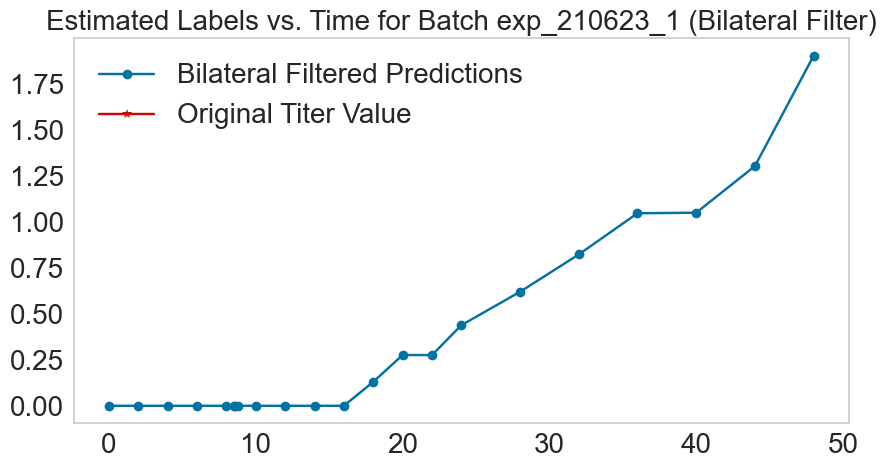

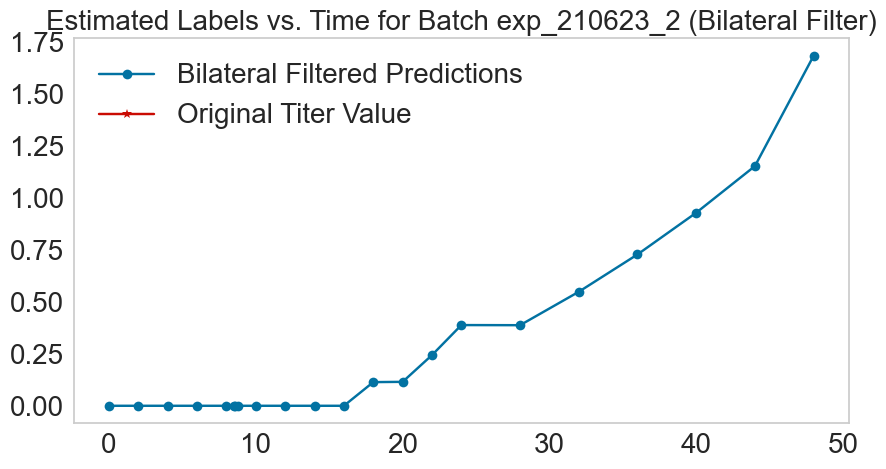

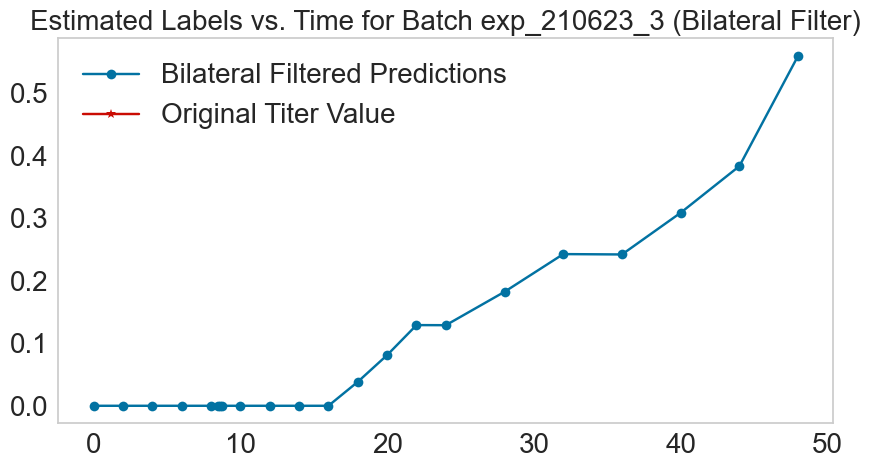

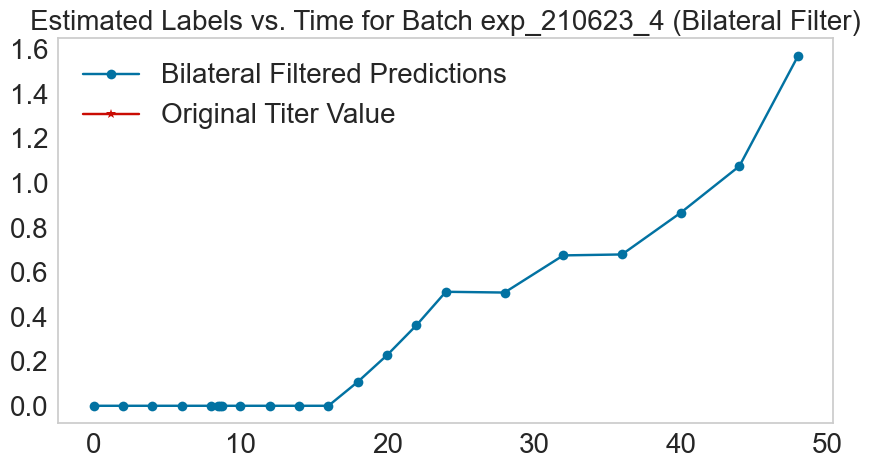

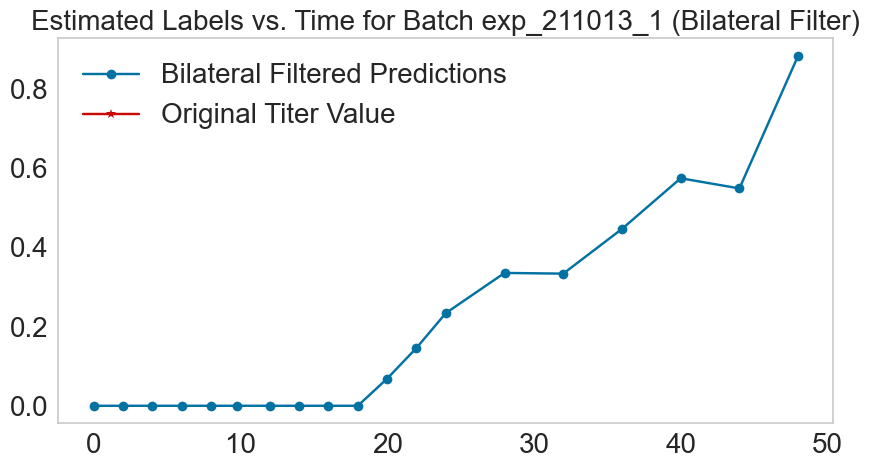

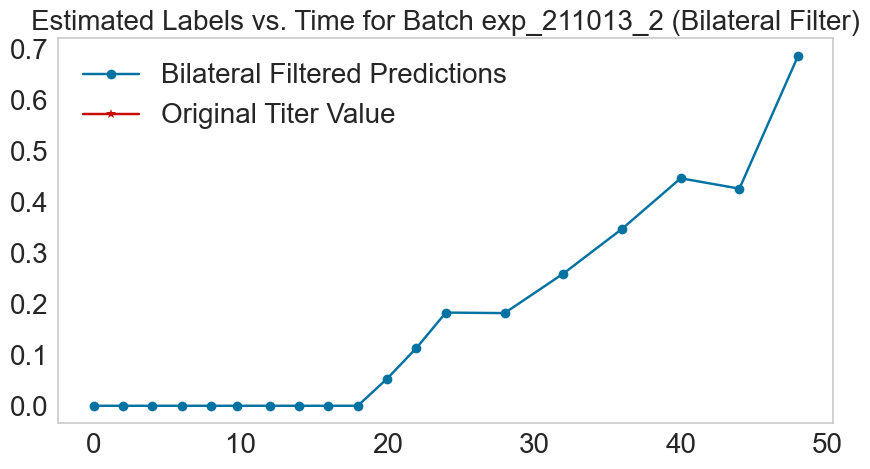

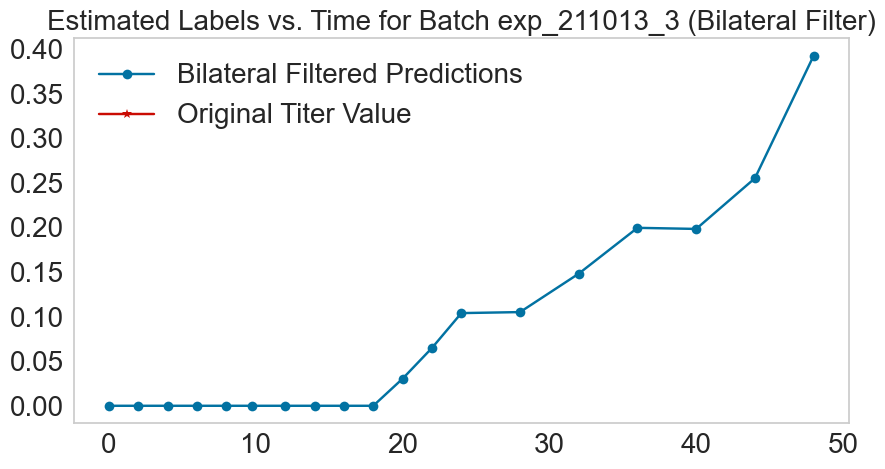

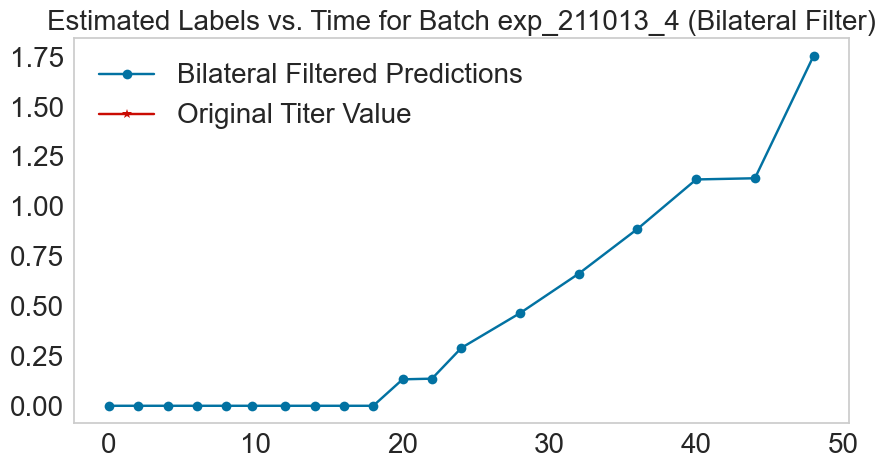

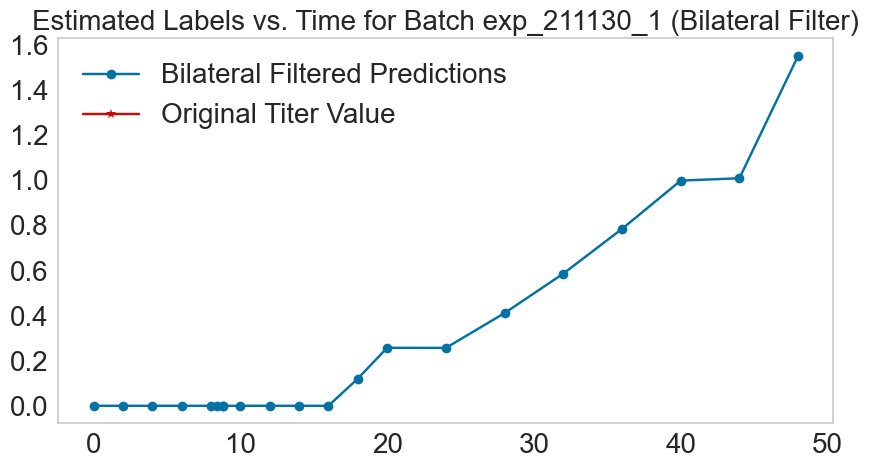

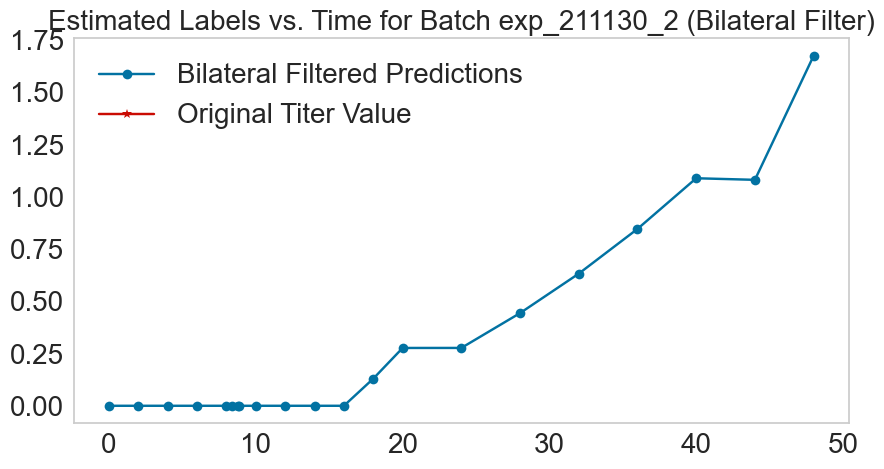

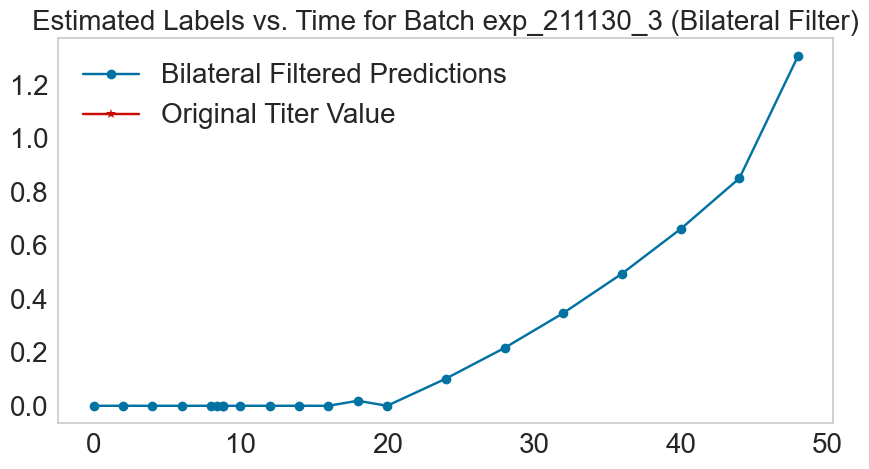

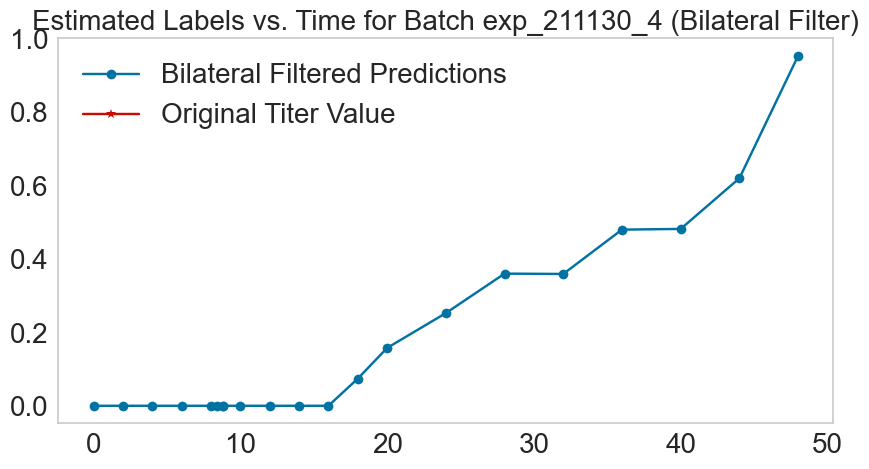

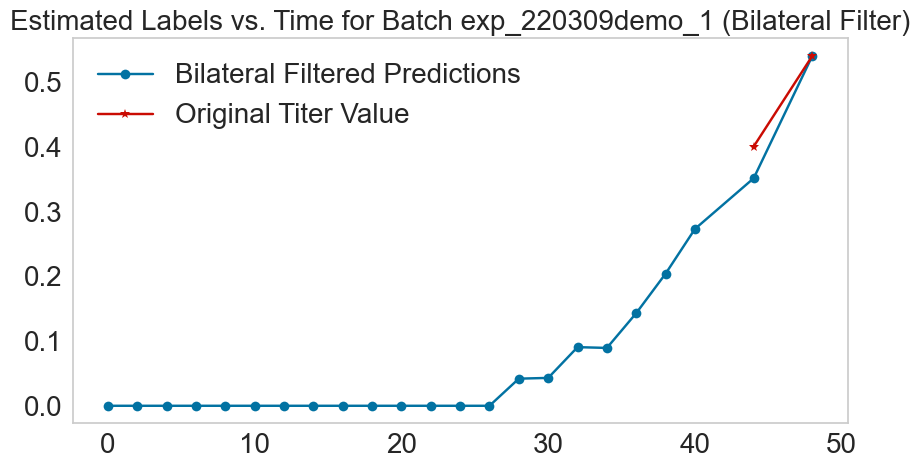

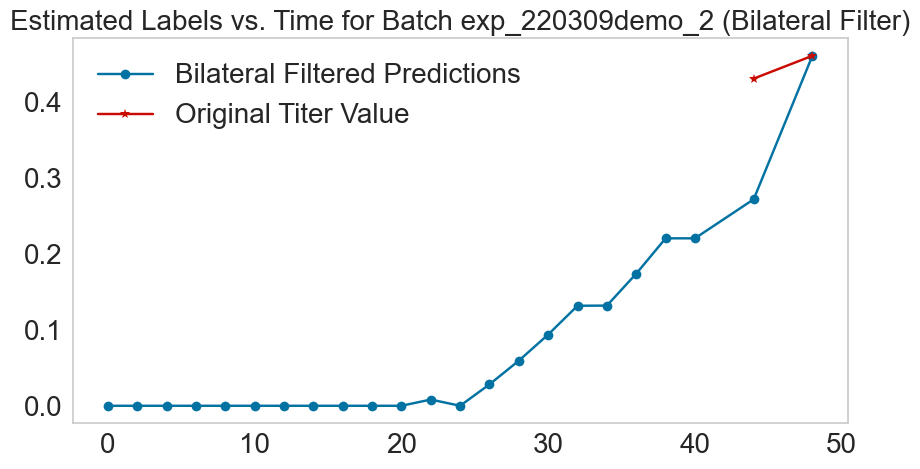

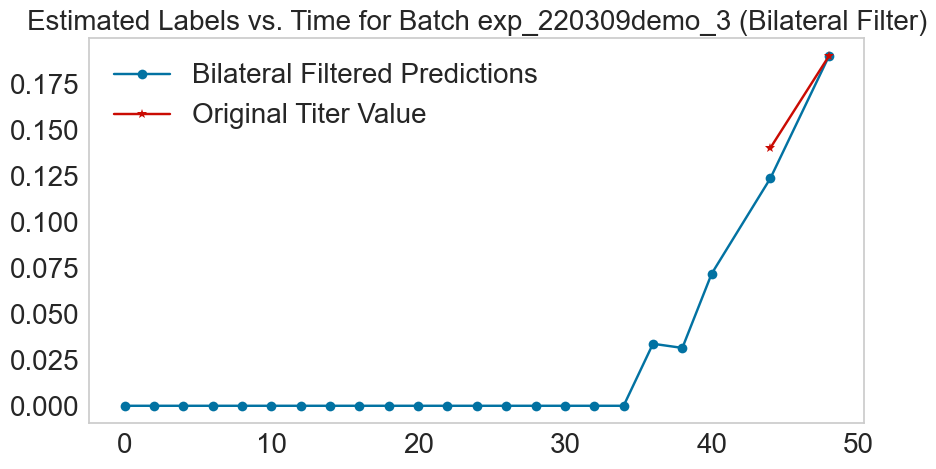

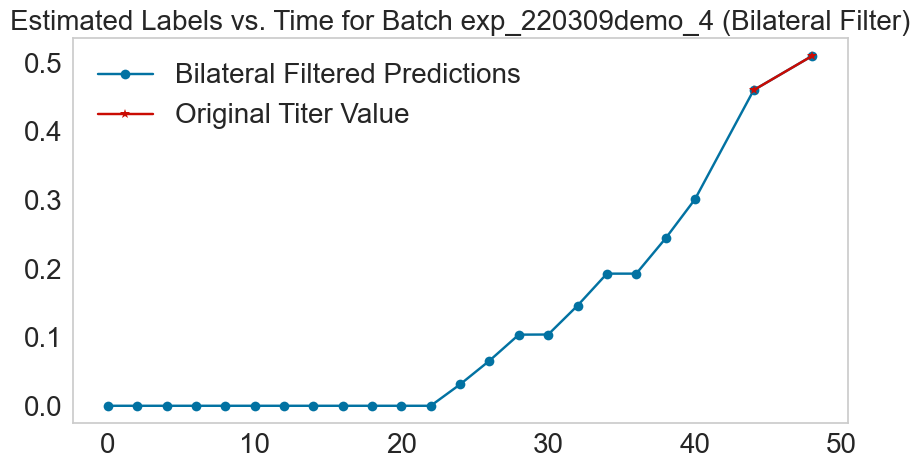

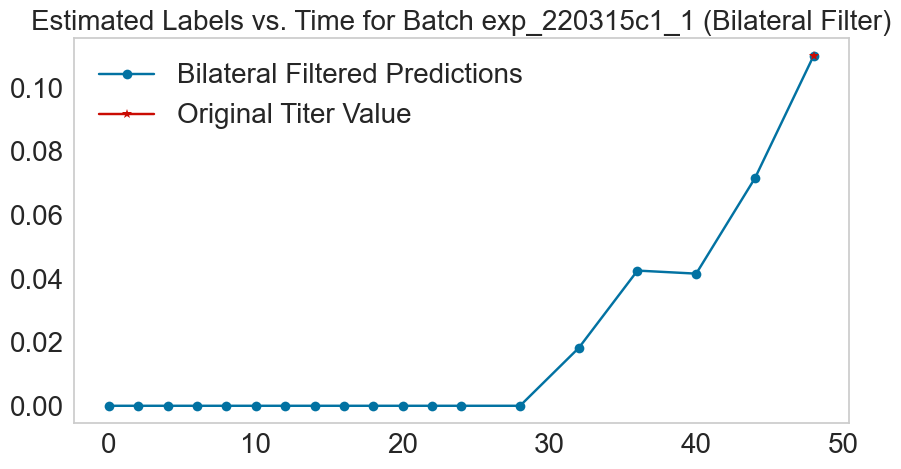

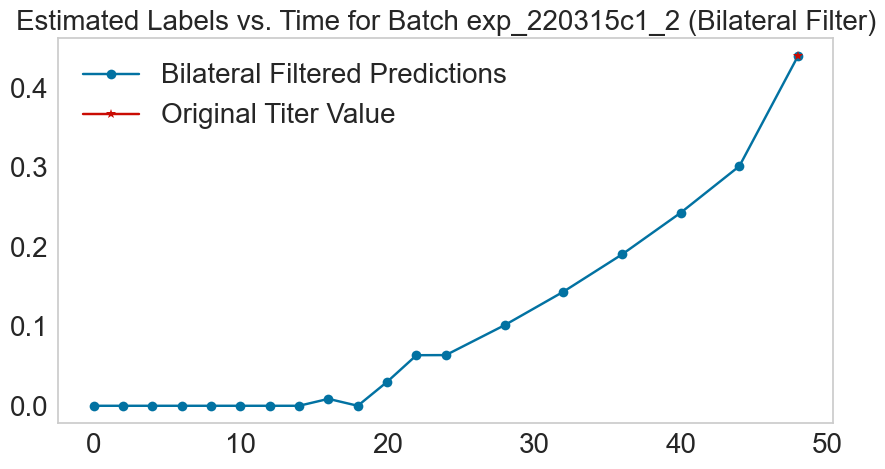

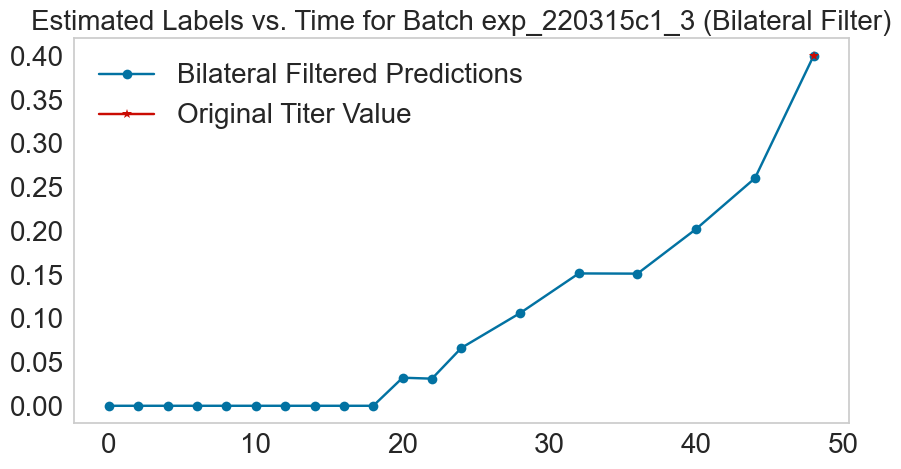

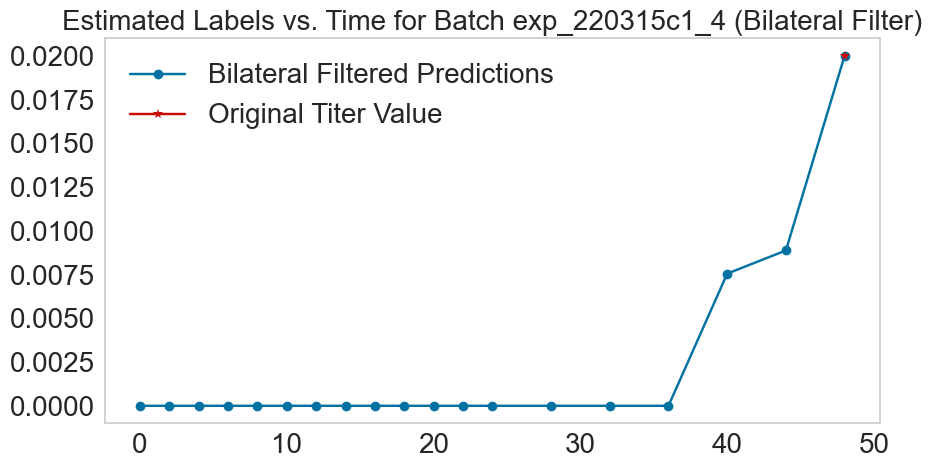

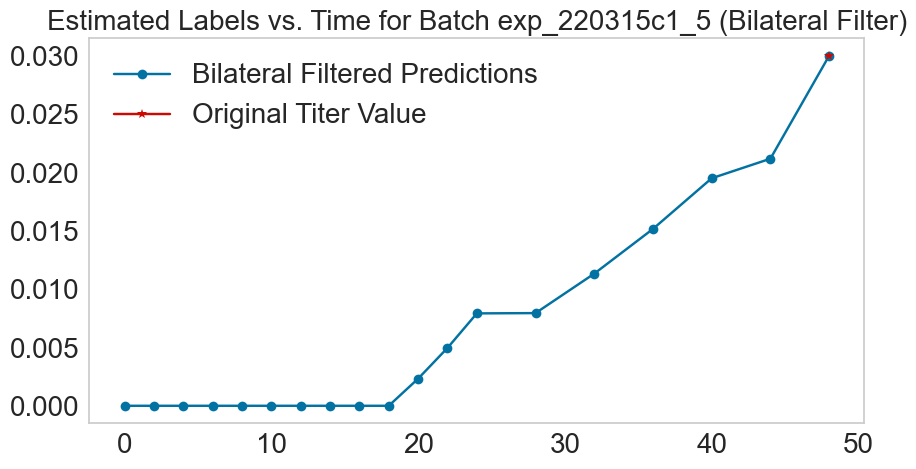

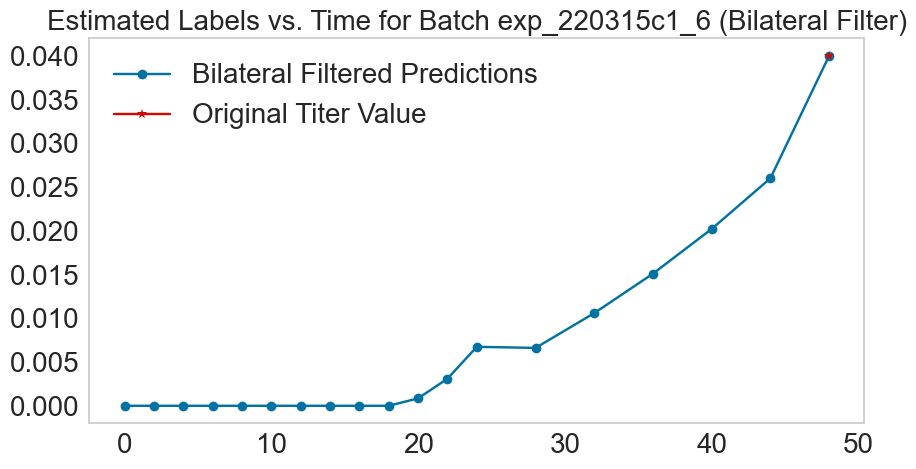

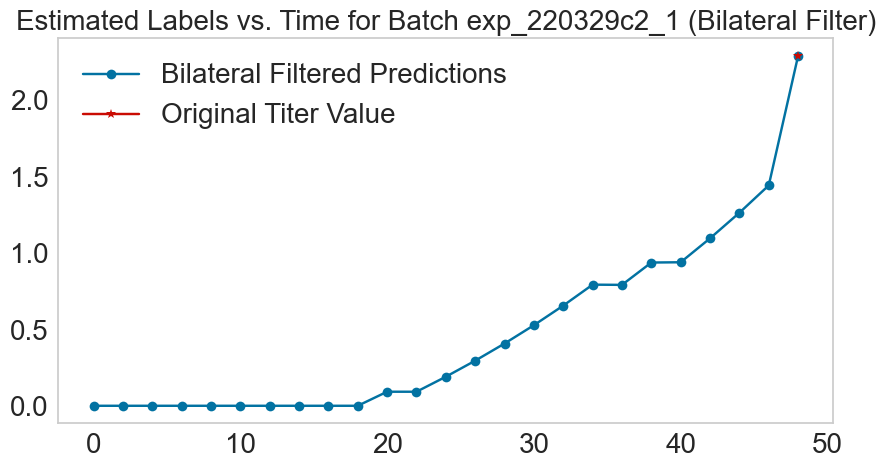

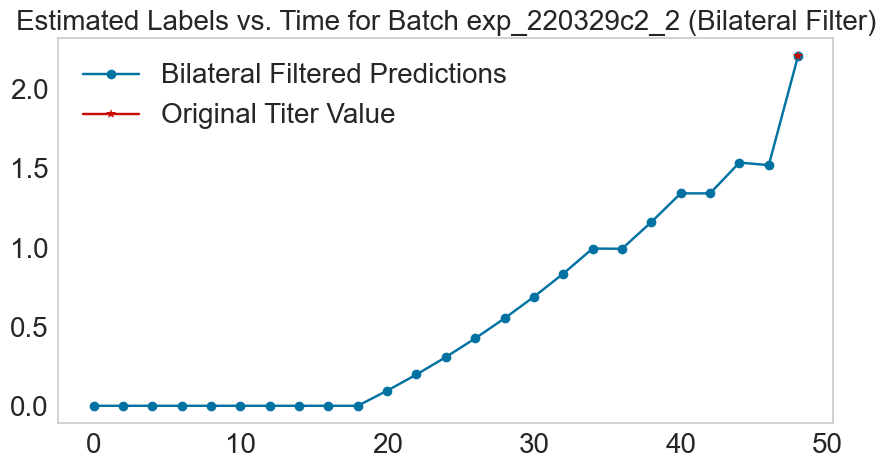

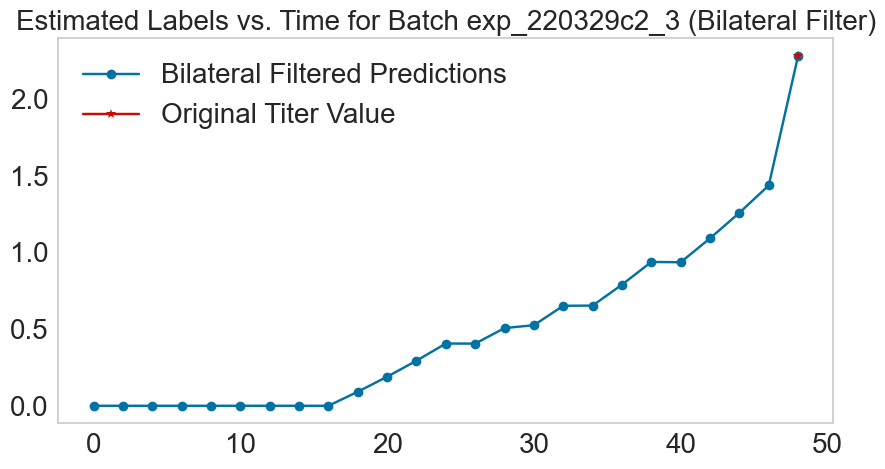

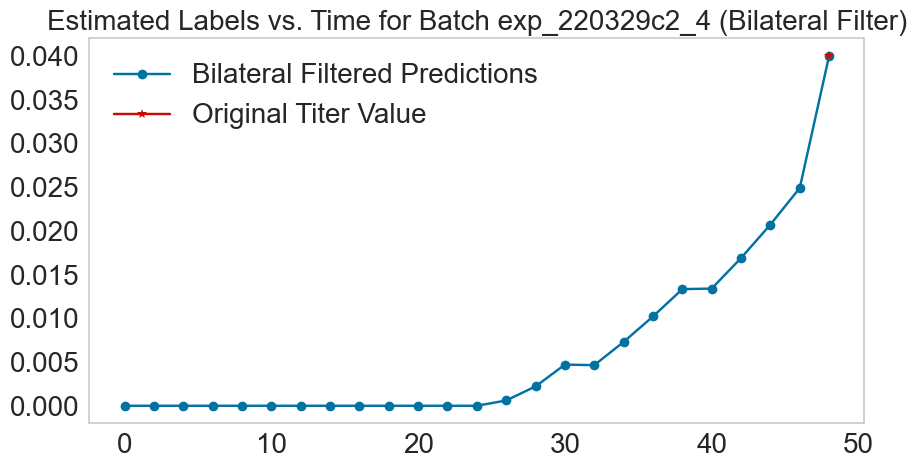

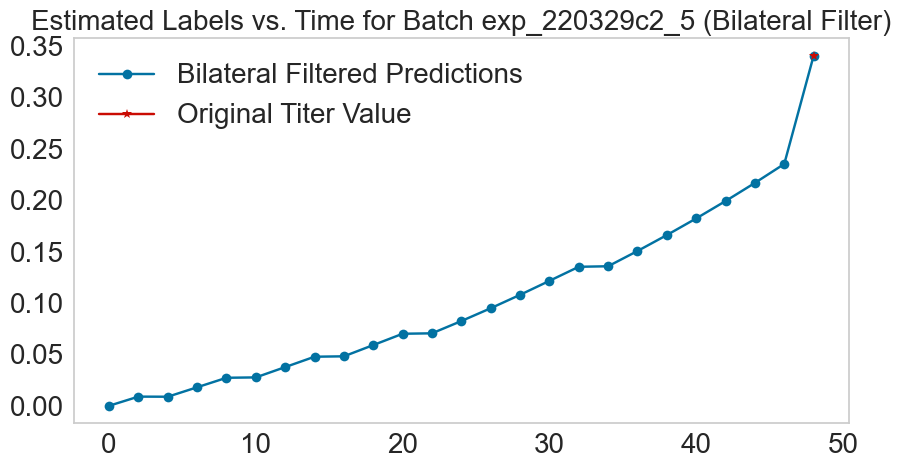

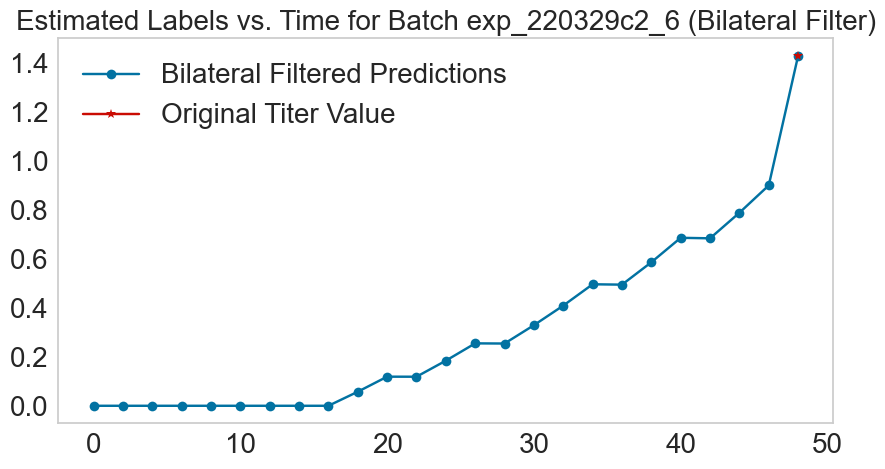

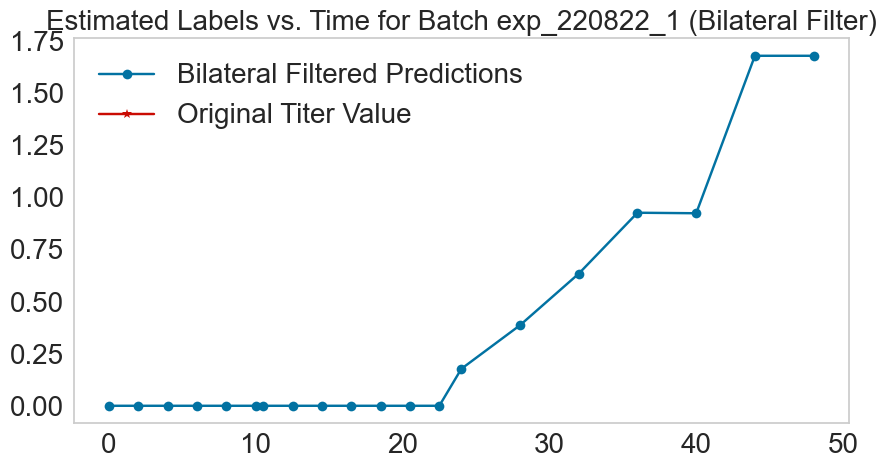

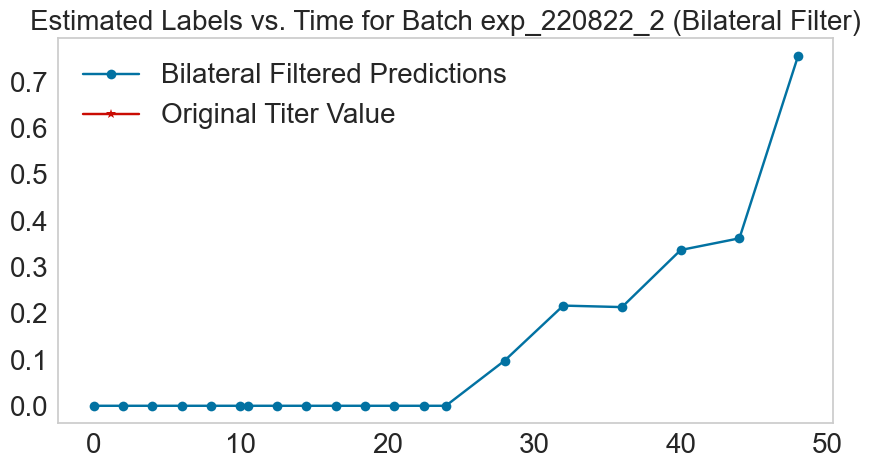

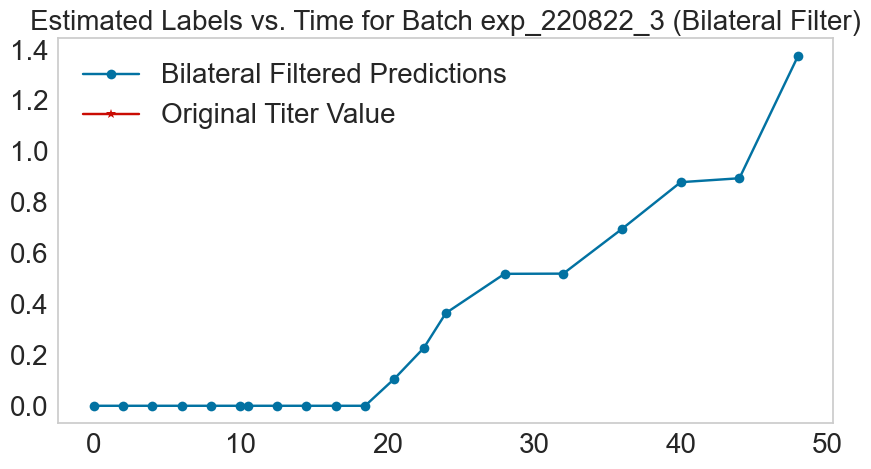

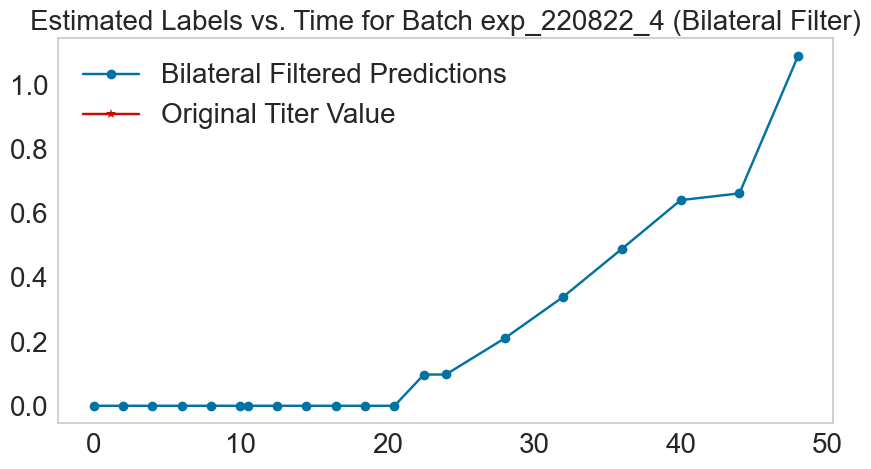

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Padding classes
class ZeroPadder:
    def __init__(self, padding_size):
        self.padding_size = padding_size

    def transform(self, seq):
        return np.pad(seq, (self.padding_size, self.padding_size), 'constant', constant_values=0)

class SamePadder:
    def __init__(self, padding_size):
        self.padding_size = padding_size

    def transform(self, seq):
        return np.pad(seq, (self.padding_size, self.padding_size), 'edge')

class IdenticalPadder:
    def __init__(self, padding_size):
        self.padding_size = padding_size

    def transform(self, seq):
        return seq

# BaseSpatialFilter and subclasses from filt.py
class BaseSpatialFilter():
    def __init__(self, win_size=3, padding="same", n_iter=1):
        assert win_size % 2 == 1, "window size must be odd value."
        assert padding in ("zero", "same", "identical"), "padding method has to be `zero`, `same` or `identical`."

        self.win_size = win_size
        self.padder = self.get_padder(padding, {"padding_size": win_size // 2})
        self.med_idx = win_size // 2
        self.n_iter = n_iter

    def fit(self, seq):
        self.seq_ = seq
        self.seq_padded_ = self.padder.transform(seq)
        return self

    def transform(self, seq):
        for _ in range(self.n_iter):
            x = self.seq_padded_
            filt = [self._filt(np.array(xs)) for xs in self.window(x, n=self.win_size)]
            x = np.hstack(filt)
            self.seq_padded_ = self.padder.transform(x)
        return x

    def fit_transform(self, seq):
        self.fit(seq)
        return self.transform(seq)

    @staticmethod
    def window(seq, n=3):
        it = iter(seq)
        result = tuple(itertools.islice(it, n))
        if len(result) == n:
            yield result
        for elem in it:
            result = result[1:] + (elem,)
            yield result

    @staticmethod
    def get_padder(padding, kwargs):
        if padding == "zero":
            return ZeroPadder(**kwargs)
        elif padding == "same":
            return SamePadder(**kwargs)
        elif padding == "identical":
            return IdenticalPadder(**kwargs)
        else:
            raise ValueError(f"Unknown padding method: {padding}")

class BilateralFilter(BaseSpatialFilter):
    def __init__(self, win_size, padding="same", n_iter=1, sigma_d=None, sigma_i=None):
        super().__init__(win_size, padding, n_iter)
        if sigma_d is None:
            sigma_d = self._suggest_sigma_d()
        self.sigma_d = sigma_d
        self.weight = norm.pdf(np.arange(win_size), loc=self.med_idx, scale=self.sigma_d)
        self.weight /= self.weight.sum()
        self.sigma_i = sigma_i

    def _filt(self, sub_seq):
        if self.sigma_i is None:
            self.sigma_i = self._suggest_sigma_i()
        w = norm.pdf(sub_seq, loc=sub_seq[self.med_idx], scale=self.sigma_i)
        weight = self.weight * w
        weight /= weight.sum()
        prod = weight.reshape(1, -1) @ sub_seq.reshape(-1, 1)
        return prod[0, 0]

    def _suggest_sigma_i(self):
        x = self.seq_
        return (x.max() - x.min()) / 100.0

# Example implementation for BilateralFilter
def bilateral_filter(data, win_size=5, padding="same", n_iter=1, sigma_d=None, sigma_i=None):
    filter = BilateralFilter(win_size=win_size, padding=padding, n_iter=n_iter, sigma_d=sigma_d, sigma_i=sigma_i)
    return filter.fit_transform(data)

# Function to directly apply bilateral filter for imputation of missing values
def impute_with_bilateral_filter(titer_values, win_size=5, sigma_d=1.0, sigma_i=0.1):
    titer_values = np.array(titer_values)
    imputed_titer = titer_values.copy()
    nan_indices = np.where(np.isnan(titer_values))[0]

    for idx in nan_indices:
        # Determine window bounds
        start = max(0, idx - win_size // 2)
        end = min(len(titer_values), idx + win_size // 2 + 1)

        # Extract the window, without filling NaNs
        window = titer_values[start:end]
        
        # Only apply filter on non-NaN values within the window
        valid_indices = ~np.isnan(window)
        if np.sum(valid_indices) < 2:
            continue  # Skip if there are not enough non-NaN values to apply the filter

        # Ensure window size is odd by adjusting if necessary
        valid_window = window[valid_indices]
        if len(valid_window) % 2 == 0:
            valid_window = np.append(valid_window, valid_window[-1])

        filtered_value = bilateral_filter(valid_window, win_size=len(valid_window), sigma_d=sigma_d, sigma_i=sigma_i)[len(valid_window) // 2]
        imputed_titer[idx] = filtered_value

    return imputed_titer

# Main function to train and evaluate spatial filter
def train_evaluate_spatial_filter(dataset, filter_type='bilateral', **kwargs):
    unique_batches = dataset['batch'].unique()
    spatial_results = []

    for batch in unique_batches:
        batch_data = dataset[dataset['batch'] == batch]

        labels = batch_data['original_titer'].to_numpy()
        labels_2 = batch_data['output_titre_µgl'].to_numpy()
        time_vector = batch_data['input_Timepoint (hr)'].to_numpy()

        batch_data = batch_data.drop(columns=['batch', 'original_titer', 'input_batch'], axis=1)
        titer_values = batch_data['output_titre_µgl'].to_numpy()

        # Impute missing values directly using the bilateral filter
        imputed_titer_values = impute_with_bilateral_filter(titer_values, **kwargs)

        # Create DataFrame for filtered results
        filtered_df = pd.DataFrame({
            'original_timepoint': time_vector,
            'original_titer': labels,
            'output_titre_µgl': imputed_titer_values,
            'output_titre_µgl_2': labels_2
        })
        spatial_results.append((filtered_df, batch))

    return spatial_results

# Bilateral Filter with default parameters
bilateral_results = train_evaluate_spatial_filter(dataset, filter_type='bilateral', win_size=5, sigma_d=1.0, sigma_i=0.1)

font_size = 20

# Plotting results for Bilateral Filter
for batch_data, batch_name in bilateral_results:
    plt.figure(figsize=(10, 5))
    plt.plot(batch_data['original_timepoint'], batch_data['output_titre_µgl'], marker='o', linestyle='-', color='b', label='Bilateral Filtered Predictions')
    plt.plot(batch_data['original_timepoint'], batch_data['original_titer'], marker='*', linestyle='-', color='r', label='Original Titer Value')
    plt.title(f'Estimated Labels vs. Time for Batch {batch_name} (Bilateral Filter)', fontsize=font_size)
    # plt.xlabel('Time (hours)')
    # plt.ylabel('Output Titre (µg/L)')
    plt.grid(False)
    plt.legend(fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.savefig(f'titer/Results/Bilateral Filters/Escherichia/bilateral_{batch_name}.png')
    plt.show()


In [10]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize
# from sklearn.metrics import mean_squared_error
# import torch
# from torch import nn
# from scipy.stats import norm
# import itertools

# # Padding classes
# class ZeroPadder:
#     def __init__(self, padding_size):
#         self.padding_size = padding_size

#     def transform(self, seq):
#         return np.pad(seq, (self.padding_size, self.padding_size), 'constant', constant_values=0)

# class SamePadder:
#     def __init__(self, padding_size):
#         self.padding_size = padding_size

#     def transform(self, seq):
#         return np.pad(seq, (self.padding_size, self.padding_size), 'edge')

# class IdenticalPadder:
#     def __init__(self, padding_size):
#         self.padding_size = padding_size

#     def transform(self, seq):
#         return seq

# # Functions and Classes for DynamicSpatialFilter
# def soft_thresholding(x, b, a=None):
#     if a is None:
#         a = b
#     return (torch.clamp(x - b, min=0) * (x > 0) +
#             torch.clamp(x + a, max=0) * (x <= 0))

# def logm_eig(A, spd=True):
#     e, v = torch.symeig(A, eigenvectors=True)
#     e = torch.clamp(e, min=1e-10)
#     return v @ torch.diag_embed(torch.log(e), dim1=2, dim2=3) @ v.transpose(2, 3)


# # BaseSpatialFilter and subclasses from filt.py
# import abc

# class BaseSpatialFilter():
#     def __init__(self, win_size=3, padding="same", n_iter=1):
#         assert win_size % 2 == 1, "window size must be odd value."
#         assert padding in ("zero", "same", "identical"), "padding method has to be `zero`, `same` or `identical`."

#         self.win_size = win_size
#         self.padder = self.get_padder(padding, {"padding_size": win_size // 2})
#         self.med_idx = win_size // 2
#         self.n_iter = n_iter

#     def fit(self, seq):
#         self.seq_ = seq
#         self.seq_padded_ = self.padder.transform(seq)
#         return self

#     def transform(self, seq):
#         for i in range(self.n_iter):
#             x = self.seq_padded_
#             filt = [self._filt(np.array(xs)) for xs in self.window(x, n=self.win_size)]
#             x = np.hstack(filt)
#             self.seq_padded_ = self.padder.transform(x)
#         return x

#     def fit_transform(self, seq):
#         self.fit(seq)
#         return self.transform(seq)

#     @abc.abstractmethod
#     def _filt(self, sub_seq):
#         pass

#     @staticmethod
#     def window(seq, n=3):
#         it = iter(seq)
#         result = tuple(itertools.islice(it, n))
#         if len(result) == n:
#             yield result
#         for elem in it:
#             result = result[1:] + (elem,)
#             yield result

#     @staticmethod
#     def get_padder(padding, kwargs):
#         if padding == "zero":
#             return ZeroPadder(**kwargs)
#         elif padding == "same":
#             return SamePadder(**kwargs)
#         elif padding == "identical":
#             return IdenticalPadder(**kwargs)
#         else:
#             raise ValueError(f"Unknown padding method: {padding}")

# class BilateralFilter(BaseSpatialFilter):
#     def __init__(self, win_size, padding="same", n_iter=1, sigma_d=None, sigma_i=None):
#         super().__init__(win_size, padding, n_iter)
#         if sigma_d is None:
#             sigma_d = self._suggest_sigma_d()
#         self.sigma_d = sigma_d
#         self.weight = norm.pdf(np.arange(win_size), loc=self.med_idx, scale=self.sigma_d)
#         self.weight /= self.weight.sum()
#         self.sigma_i = sigma_i

#     def _filt(self, sub_seq):
#         if self.sigma_i is None:
#             self.sigma_i = self._suggest_sigma_i()
#         w = norm.pdf(sub_seq, loc=sub_seq[self.med_idx], scale=self.sigma_i)
#         weight = self.weight * w
#         weight /= weight.sum()
#         prod = weight.reshape(1, -1) @ sub_seq.reshape(-1, 1)
#         return prod[0, 0]

#     def _suggest_sigma_i(self):
#         x = self.seq_
#         return (x.max() - x.min()) / 100.0


# # Example implementation for BilateralFilter
# def bilateral_filter(data, win_size=5, padding="same", n_iter=1, sigma_d=None, sigma_i=None):
#     filter = BilateralFilter(win_size=win_size, padding=padding, n_iter=n_iter, sigma_d=sigma_d, sigma_i=sigma_i)
#     return filter.fit_transform(data)

# # Main function to train and evaluate spatial filter
# def train_evaluate_spatial_filter(dataset, filter_type='dynamic', **kwargs):
#     print(f"Training and evaluating filter: {filter_type}")
#     unique_batches = dataset['batch'].unique()
#     spatial_results = []

#     for batch in unique_batches:
#         batch_data = dataset[dataset['batch'] == batch]
#         labels = batch_data['original_titer'].to_numpy()
#         labels_2 = batch_data['output_titre_µgl'].to_numpy()
#         time_vector = batch_data['input_Timepoint (hr)'].to_numpy()

#         batch_data = batch_data.drop(columns=['batch', 'original_titer', 'input_batch'], axis=1)
#         titer_values = batch_data['output_titre_µgl'].to_numpy().reshape(-1, 1)

#         if filter_type == 'dynamic':
#             print("Applying dynamic spatial filter")
#             estimated_titer = dynamic_spatial_filter(titer_values, **kwargs)
#         elif filter_type == 'bilateral':
#             estimated_titer = bilateral_filter(titer_values, **kwargs)
#         elif filter_type == 'non_local_mean':
#             print("Applying non-local mean filter")
#             estimated_titer = non_local_mean_filter(titer_values, **kwargs)
#         else:
#             raise ValueError("Unsupported filter type")

#         # Create DataFrame for filtered results
#         filtered_df = pd.DataFrame({
#             'original_timepoint': time_vector,
#             'original_titer': labels,
#             'output_titre_µgl': estimated_titer,
#             'output_titre_µgl_2': labels_2
#         })
#         spatial_results.append((filtered_df, batch))

#     return spatial_results

# def objective_function(params, dataset, filter_type='dynamic'):
#     kwargs = {'sigma_d': params[0]} if filter_type == 'bilateral' else {'sigma': params[0]} if filter_type == 'non_local_mean' else {'ratio': params[0]}
#     results = train_evaluate_spatial_filter(dataset, filter_type=filter_type, **kwargs)
#     mse_list = []
#     for batch_data, _ in results:
#         mse = mean_squared_error(batch_data['output_titre_µgl_2'], batch_data['output_titre_µgl'])
#         mse_list.append(mse)
#     return np.mean(mse_list)

# def optimize_hyperparameters(dataset, filter_type='dynamic'):
#     from scipy.optimize import minimize
    
#     initial_guess = [1.0]
#     bounds = [(0.1, 10.0)]
    
#     result = minimize(objective_function, initial_guess, args=(dataset, filter_type), bounds=bounds, method='L-BFGS-B')
#     best_params = result.x
#     return best_params


# # Bilateral Filter 
# best_params = optimize_hyperparameters(dataset, filter_type='bilateral')
# bilateral_results = train_evaluate_spatial_filter(dataset, filter_type='bilateral', sigma_d=best_params[0])

# # Plotting results for Bilateral Filter
# for batch_data, batch_name in bilateral_results:
#     plt.figure(figsize=(10, 5))
#     plt.plot(batch_data['original_timepoint'], batch_data['output_titre_µgl'], marker='o', linestyle='-', color='b', label='Bilateral Filtered Predictions')
#     plt.plot(batch_data['original_timepoint'], batch_data['original_titer'], marker='*', linestyle='-', color='r', label='Original Titer Value') 
#     plt.title(f'Estimated Labels vs. Time for Batch {batch_name} (Bilateral Filter)')
#     plt.xlabel('Time (hours)')
#     plt.ylabel('Output Titre (µg/L)')
#     plt.grid(True)
#     plt.legend()
#     plt.savefig(f'titer/Results/Bilateral Filters/Escherichia/bilateral_{batch_name}.png') 
#     plt.show()
